In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

#root_dir = '/content/gdrive/MyDrive/Data'

root_dir = '../../../Data'

Mounted at /content/gdrive


In [3]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from pandas.core.frame import DataFrame
from time import sleep
import math
from tensorflow.keras import layers

Extracting labels

Getting participants section in the merged file

In [ ]:
experience = 8
data_loading_dir = os.path.join(root_dir, "18 participants/AX3/DownsampledDataset" + str(experience))
participants = 1
sections = [0]
count = 0

for participant in range(1, participants + 1):
  file_name = os.path.join(data_loading_dir, "Dataset_participant" + str(participant) + ".pkl")
  new_dataset = pd.read_pickle(file_name)
  count = count + new_dataset.shape[0]
  sections.append(count)

data_loading_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
save_file = os.path.join(data_loading_dir, "Sections.pkl")

sections_df = DataFrame({'Sections': sections})
sections_df.to_pickle(save_file)
#print(sections_df)

Extracting labelled and unlabelled dataset

In [ ]:
participants = 1
experience = 8

psg_dir = os.path.join(root_dir, "18 participants/PSG")
features_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))

# PSG Files
PSG_Consensus_Sleep_profile = "SDRI001_PSG_Consensus Sleep profile_0"
PSG_Heart_Rate = "SDRI001_PSG_Heart Rate_0"
PSG_HRV_HF = "SDRI001_PSG_HRV HF_0"
PSG_HRV_LF = "SDRI001_PSG_HRV LF_0"
PSG_Position = "SDRI001_PSG_Position_0"
PSG_RR_Interval = "SDRI001_PSG_RR-Interval_0"
PSG_SpO2 = "SDRI001_PSG_SpO2_0"

def get_PSG_dataset(PSF_DIR, PSG_File, participant):
  file_name = os.path.join(PSF_DIR, PSG_File + str(participant).zfill(2) + "V4_N1.txt")
  dataset = pd.read_csv(file_name, sep=" ")
  return dataset

def reformatPSGDatetime(date, time):
  #File 9 Anamoly
  if not isinstance(date, str):
    after_midnight = 0
    if int(time[:2]) < 22:
      after_midnight = 1
    date = str(26+after_midnight) + ".02.2020"

  date = date.split('.')
  time = time.split(',')[0]
  datetime = date[2] + '-' + date[1] + '-' + date[0] + ' ' + time
  return datetime

def extractSleepProfileLabels(dataset, starting_rows=5):
  columns = np.array(dataset.columns)
  columns[0] = 'Date'
  columns[1] = 'Time'
  columns[2] = 'Sleep State'
  dataset.columns = columns
  dataset = dataset.iloc[starting_rows:]
  dataset['Label'] = dataset.apply(lambda x: reformatPSGDatetime(x['Date'], x['Time']), axis=1)
  dataset = dataset[['Label', 'Sleep State']]
  return dataset

def extractNonSleepProfileLabels(dataset, starting_rows=5):
  columns = np.array(dataset.columns)
  columns[0] = 'Date'
  columns[1] = 'Time'
  columns[2] = 'Value'
  columns[3] = 'Sleep State'
  #File 9 Anamoly
  if ',' in dataset.iloc[starting_rows][0]:
    columns[0] = 'Time'
    columns[1] = 'Value'
    columns[2] = 'Sleep State'
    columns[3] = 'Date'
    dataset.columns = columns
    print(dataset.iloc[starting_rows]['Date'])

  dataset.columns = columns
  dataset = dataset.iloc[starting_rows:]
  dataset['Label'] = dataset.apply(lambda x: reformatPSGDatetime(x['Date'], x['Time']), axis=1)
  dataset = dataset[['Label', 'Value', 'Sleep State']]
  return dataset

def get_Features_dataset(features_dir, file="Features.pkl"):
  file_name = os.path.join(features_dir, file)
  dataset = pd.read_pickle(file_name)
  return dataset

def getSection(features_dir):
  file_name = os.path.join(features_dir, "Sections.pkl")
  dataset = pd.read_pickle(file_name)
  dataset = np.array(dataset)
  return dataset.reshape(dataset.shape[0])

def get_Feature_Dataset(sections, features_dataset, participant):
  from_idx = sections[participant-1]
  to_idx = sections[participant]
  return features_dataset.iloc[from_idx:to_idx]

def extract_unlabelled_dataset(feature_dataset, psg_dataset):
  feature_dataset = pd.merge(feature_dataset, psg_dataset, how='left', on="Label")
  return feature_dataset[feature_dataset['Sleep State'].isnull()]

def SaveDataset(dataset, file_name):
  save_file = os.path.join(features_dir, file_name)
  dataset.to_pickle(save_file)

features_dataset = get_Features_dataset(features_dir)
raw_dataset = get_Features_dataset(features_dir, "Raw.pkl")
sections = getSection(features_dir)

Extracting labels of Heart rate and Positions dataset


In [ ]:
#for i in range(1, 2):
  #psg_dataset = get_PSG_dataset(psg_dir, PSG_Heart_Rate, i)
  #psg_dataset = psg_dataset.reset_index()
  #psg_dataset = extractNonSleepProfileLabels(psg_dataset)

  #psg_dataset = get_PSG_dataset(psg_dir, PSG_Position, i)
  #psg_dataset = extractNonSleepProfileLabels(psg_dataset, 6)
  #print(psg_dataset.shape)
  #print(psg_dataset.head(7))

psg_dataset = get_PSG_dataset(psg_dir, PSG_Heart_Rate, 1)
psg_dataset = psg_dataset.reset_index()
psg_dataset = extractNonSleepProfileLabels(psg_dataset, 6)
feature_dataset = get_Feature_Dataset(sections, features_dataset, 1)

labelled_dataset = pd.merge(feature_dataset, psg_dataset, on="Label")
unlabelled_dataset = extract_unlabelled_dataset(feature_dataset, psg_dataset)

for participant in range(2, participants + 1):
  psg_dataset = get_PSG_dataset(psg_dir, PSG_Heart_Rate, participant)
  psg_dataset = psg_dataset.reset_index()
  print(psg_dataset.shape)

  psg_dataset = extractNonSleepProfileLabels(psg_dataset, 6)
  feature_dataset = get_Feature_Dataset(sections, features_dataset, participant)

  new_labelled_dataset = pd.merge(feature_dataset, psg_dataset, on="Label")
  new_unlabelled_dataset = extract_unlabelled_dataset(feature_dataset, psg_dataset)

  labelled_dataset = labelled_dataset.append(new_labelled_dataset, ignore_index=True)
  unlabelled_dataset = unlabelled_dataset.append(new_unlabelled_dataset, ignore_index=True)

SaveDataset(labelled_dataset, "LabelledHR")
SaveDataset(unlabelled_dataset, "UnlabelledHR")

print(feature_dataset.shape)
print(labelled_dataset.shape)
print(unlabelled_dataset.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(24620, 71)
(1199, 73)
(23421, 73)


Extracting labels of Sleep profile dataset

In [ ]:
psg_dataset = get_PSG_dataset(psg_dir, PSG_Consensus_Sleep_profile, 1)
psg_dataset = extractSleepProfileLabels(psg_dataset)
feature_dataset = get_Feature_Dataset(sections, features_dataset, 1)

labelled_dataset = pd.merge(feature_dataset, psg_dataset, on="Label")
unlabelled_dataset = extract_unlabelled_dataset(feature_dataset, psg_dataset)

for participant in range(2, participants + 1):
  psg_dataset = get_PSG_dataset(psg_dir, PSG_Consensus_Sleep_profile, participant)
  psg_dataset = extractSleepProfileLabels(psg_dataset)
  feature_dataset = get_Feature_Dataset(sections, features_dataset, participant)

  new_labelled_dataset = pd.merge(feature_dataset, psg_dataset, on="Label")
  new_unlabelled_dataset = extract_unlabelled_dataset(feature_dataset, psg_dataset)

  labelled_dataset = labelled_dataset.append(new_labelled_dataset, ignore_index=True)
  unlabelled_dataset = unlabelled_dataset.append(new_unlabelled_dataset, ignore_index=True)

train_to_test_ratio = 0.9
n = labelled_dataset.shape[0]
split_point = n * train_to_test_ratio

SaveDataset(labelled_dataset, "Labelled")
SaveDataset(unlabelled_dataset, "Unlabelled")

print(psg_dataset.shape)
print(feature_dataset.shape)
print(labelled_dataset.shape)
print(unlabelled_dataset.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(1201, 2)
(24620, 71)
(1201, 72)
(23419, 72)


PseudoLabeling module

In [6]:
experience = 8

features_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
file_name = os.path.join(features_dir, "Labelled")

def encode_sleep_stage(val):
  arr = {'N1':0, 'N2':1, 'N3':2, 'REM':3, 'Wake':4, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

def encode_sleep_state(val):
  arr = {'N1':0, 'N2':1, 'N3':2, 'REM':3, 'Wake':4, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

dataset = pd.read_pickle(file_name)
dataset['Sleep State'] = dataset['Sleep State'].apply(lambda x: encode_sleep_stage(x))
dataset['Sleep State'] = pd.Series(np.array(dataset['Sleep State'])).interpolate()
dataset['Sleep State'] = np.array(dataset['Sleep State'].replace(to_replace = np.nan, value=4), dtype=np.int64)


Pairing the data

In [14]:
def pair_dataset(dataset, number_of_columns, multiply_pairing = 1):
  datasets = []
  ratios_column = []
  data_count = int(dataset.shape[0])

  for i in range(number_of_columns):
    dataset_portion = dataset[dataset['Sleep State']==i].reset_index(drop=True)
    ratios_column.append(round(dataset_portion.shape[0]/dataset.shape[0],2))
    datasets.append(dataset_portion)

  x_pair1 = []
  x_pair2 = []
  y_label = []

  pair1_labels = []
  pair2_labels = []

  for i in range(number_of_columns):
    class_dataset = datasets[i]
    class_dataset_size = class_dataset.shape[0]
    for j in range(i, number_of_columns):
      multiply = multiply_pairing
      #if (i == j):
        #multiply = multiply * (number_of_columns - 1) * 2
      for k in range(multiply):
        class_dataset2 = datasets[j]
        randIdx = [random.randint(0,class_dataset2.shape[0]-1) for x in range(class_dataset_size)]

        datasets1 = class_dataset[:class_dataset_size].drop(['Label','Sleep State'], axis=1)
        datasets2 = class_dataset2.iloc[randIdx].drop(['Label','Sleep State'], axis=1)
        
        labels = np.zeros(class_dataset_size)
        if i == j:
          labels = np.ones(class_dataset_size)

        dataset1_labels = np.full((class_dataset_size),i)
        dataset2_labels = np.full((class_dataset_size),j)

        if (x_pair1==[]):
          x_pair1 = np.array(datasets1)
          x_pair2 = np.array(datasets2)
          y_label = labels

          pair1_labels = dataset1_labels
          pair2_labels = dataset2_labels
        else:
          x_pair1 = np.append(x_pair1, np.array(datasets1), axis=0)
          x_pair2 = np.append(x_pair2, np.array(datasets2), axis=0)
          y_label = np.append(y_label, labels, axis=0)

          pair1_labels = np.append(pair1_labels, dataset1_labels, axis=0)
          pair2_labels = np.append(pair2_labels, dataset2_labels, axis=0)
    
  return x_pair1, x_pair2, y_label, pair1_labels, pair2_labels

def train_test_split(dataset, test_train_ratio, number_bags=10):
  dataset_bag_size = int(dataset.shape[0]/number_bags)
  separation_point = int(dataset_bag_size * test_train_ratio)
  dataset_split = dataset[:dataset_bag_size]
  dataset_train = dataset_split[:separation_point]
  dataset_test = dataset_split[separation_point:]

  for i in range(1, number_bags):
    dataset_split = dataset[i*dataset_bag_size:dataset_bag_size * (i+1)]
    new_dataset_train = dataset_split[:separation_point]
    new_dataset_test = dataset_split[separation_point:]
    dataset_train = dataset_train.append(new_dataset_train, ignore_index = True)
    dataset_test = dataset_test.append(new_dataset_test, ignore_index = True)

  return dataset_train, dataset_test

def trad_test_split(dataset, test_train_ratio):
  dataset_size = dataset.shape[0]
  split_point = int(dataset_size * test_train_ratio)
  dataset_train = dataset[:split_point]
  dataset_test = dataset[split_point:]
  return dataset_train, dataset_test

def train_test_split_rand(dataset, test_train_ratio):
  n = dataset.shape[0]
  split_point = int((1-test_train_ratio) * n)
  randIdx_test = random.sample(range(0, dataset.shape[0]), split_point)
  randIdx_train = np.setdiff1d(range(0, dataset.shape[0]), randIdx_test)

  dataset_train = dataset.iloc[randIdx_train]
  dataset_test = dataset.iloc[randIdx_test]
  return dataset_train, dataset_test


def conv2_reshape(data):
  data = data.reshape(data.shape[0], data.shape[1], 1, 1)
  return data

### START RUNNING THE CODE ###

number_of_columns = 5

test_train_ratio = 0.7
#dataset_train, dataset_test = train_test_split_rand(dataset, test_train_ratio)
dataset_train, dataset_test = train_test_split(dataset, test_train_ratio, 200)
#dataset_train, dataset_test = trad_test_split(dataset, test_train_ratio)

x_train1, x_train2, y_train, y_train1, y_train2 = pair_dataset(dataset_train, number_of_columns, 200)
x_test1, x_test2, y_test, y_test1, y_test2 = pair_dataset(dataset_test, number_of_columns, 200)


labels_train = np.zeros((dataset_train.shape[0], number_of_columns))
labels_test = np.zeros((dataset_test.shape[0], number_of_columns))

train_set = conv2_reshape(np.array(dataset_train.drop(['Label','Sleep State'], axis=1)))
test_set = conv2_reshape(np.array(dataset_test.drop(['Label','Sleep State'], axis=1)))

for i in range(dataset_train.shape[0]):
  label = dataset_train.iloc[i]['Sleep State']
  labels_train[i][label] = 1

for i in range(dataset_test.shape[0]):
  label = dataset_test.iloc[i]['Sleep State']
  labels_test[i][label] = 1


x_train1 = conv2_reshape(x_train1)
x_train2 = conv2_reshape(x_train2)
x_test1 = conv2_reshape(x_test1)
x_test2 = conv2_reshape(x_test2)

print(dataset.shape)
print(x_train1.shape)
print(x_train2.shape)
print(y_train.shape)
print(x_test1.shape)
print(x_test2.shape)
print(y_test.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


(1201, 72)
(410200, 70, 1, 1)
(410200, 70, 1, 1)
(410200,)
(209000, 70, 1, 1)
(209000, 70, 1, 1)
(209000,)


Siamese Contrastive model

In [ ]:
def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )
    return contrastive_loss

def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((x_train1.shape[1], 1, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(70, (1, 1), activation="tanh")(input)
x = layers.Conv2D(35, (1, 1), activation="tanh")(x)
x = layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(128, activation="tanh")(x)
embedding_network = keras.Model(input, x)


#input = layers.Input((49,))
#x = tf.keras.layers.BatchNormalization()(input)
#x = layers.Dense(49, activation="tanh")(x)
#x = layers.Dense(23,, activation="tanh")(x)
#x = layers.Flatten()(x)
#x = tf.keras.layers.BatchNormalization()(x)
#x = layers.Dense(10, activation="tanh")(x)


input_1 = layers.Input((x_train1.shape[1],1,1))
input_2 = layers.Input((x_train1.shape[1],1,1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

output_layer_cnn = layers.Dense(5, activation="softmax")(tower_1)
cnn = keras.Model(inputs=[input_1], outputs=output_layer_cnn)

from tensorflow.keras.optimizers import RMSprop
rms = RMSprop(learning_rate=0.001)
cnn.compile(loss='categorical_crossentropy', optimizer=rms, metrics=["accuracy"])

siamese.compile(loss=loss(margin=1), optimizer='RMSprop', metrics=["accuracy"])
#siamese.summary()

#from keras.utils.vis_utils import plot_model
#plot_model(siamese, show_shapes=True, show_layer_names=True)
history = siamese.fit(
    [x_train1, x_train2],
    y_train,
    validation_data=([x_test1, x_test2], y_test),
    batch_size=16,
    epochs=5,
)

In [9]:
cont_model_file = os.path.join(features_dir, "ContModel1.pkl")
siamese.save(cont_model_file)
cont_model_file = os.path.join(features_dir, "ContFineModel1.pkl")
cnn.save(cont_model_file)


In [ ]:
from tensorflow.keras.optimizers import RMSprop
rms = RMSprop(learning_rate=0.01)
#siamese.summary()

#from keras.utils.vis_utils import plot_model
#plot_model(siamese, show_shapes=True, show_layer_names=True)
history = cnn.fit(
    train_set,
    labels_train,
    validation_data=(test_set, labels_test),
    batch_size=16,
    epochs=100,
)

test_labels = np.argmax(labels_test, axis=1)
y_pred = np.argmax(cnn.predict(test_set), axis=1)
Labels = ['N1','N2', 'N3', 'REM', 'Wake']

#cf_matrix = get_confusion_matrix(y_test, y_pred)
cf_matrix = confusion_matrix(test_labels, y_pred)

Labels = ['N1', 'N2', 'N3', 'REM', 'WAKE']
printConfusionMatrix(cf_matrix, Labels, show=True)

[[  3  22   0   3  24]
 [  0  57   7   5  23]
 [  0  33  16   1   1]
 [  0  25   0  31   3]
 [  1  33   5   2 105]]
Precision, Recall and F1 Score for N1 are 0.75, 0.06, 0.11
Precision, Recall and F1 Score for N2 are 0.34, 0.62, 0.44
Precision, Recall and F1 Score for N3 are 0.57, 0.31, 0.4
Precision, Recall and F1 Score for REM are 0.74, 0.53, 0.62
Precision, Recall and F1 Score for WAKE are 0.67, 0.72, 0.69
(5, 5)
Accuracy is 0.53


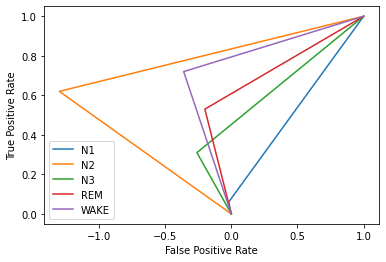

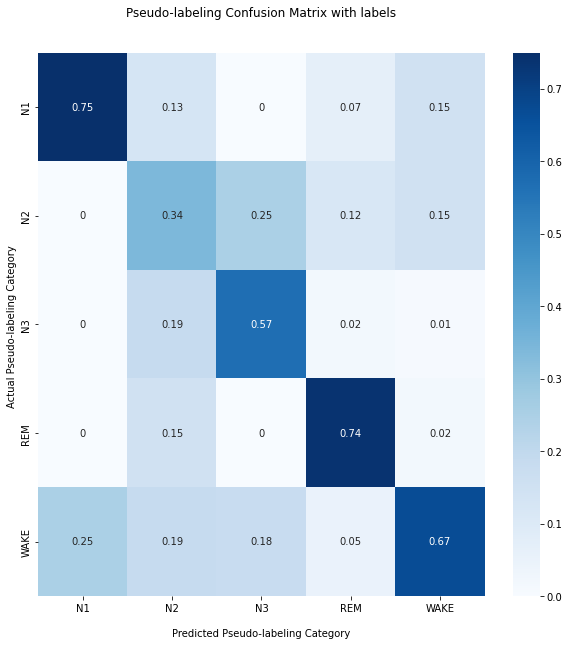

([0.75, 0.34, 0.57, 0.74, 0.67], 0.53)

In [ ]:
cf_matrix = confusion_matrix(test_labels, y_pred)

Labels = ['N1', 'N2', 'N3', 'REM', 'WAKE']
printConfusionMatrix(cf_matrix, Labels, show=True)

(800000, 70, 1, 1)
(800000, 70, 1, 1)
(1201, 72)
(400,)
[[33  8  1 10  0]
 [16 44 17  9  6]
 [ 1 14 36  0  0]
 [ 1 14  1 43  0]
 [41  5  7  5 88]]
Precision, Recall and F1 Score for N1 are 0.36, 0.63, 0.46
Precision, Recall and F1 Score for N2 are 0.52, 0.48, 0.5
Precision, Recall and F1 Score for N3 are 0.58, 0.71, 0.64
Precision, Recall and F1 Score for REM are 0.64, 0.73, 0.68
Precision, Recall and F1 Score for WAKE are 0.94, 0.6, 0.73
(5, 5)
Accuracy is 0.61


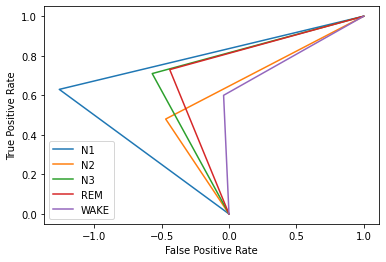

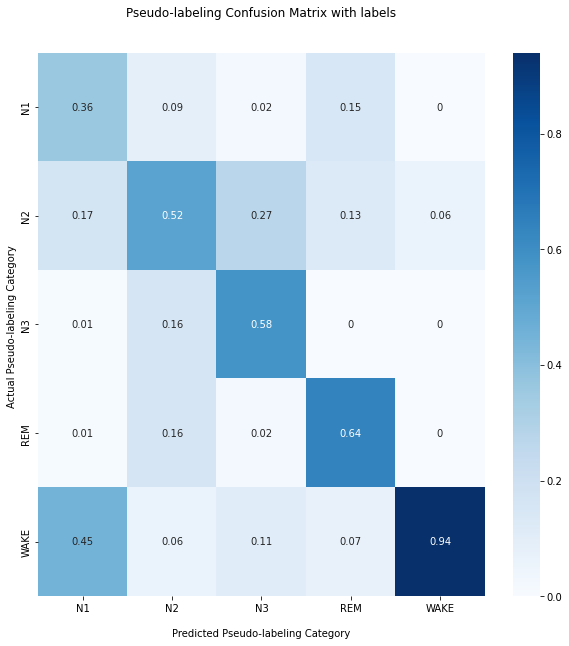

([0.36, 0.52, 0.58, 0.64, 0.94], 0.61)

In [17]:
def predict_siamese(number_of_columns, siamese, dataset_test, test_groups=10):
  data_count = int(dataset_test.shape[0])
  dataset_test = dataset_test.reset_index(drop=True)
  dataset_portion = dataset_test[dataset_test['Sleep State']==0].reset_index(drop=True)
  randIdx = [random.randint(0,dataset_portion.shape[0]-1) for x in range(test_groups)]
  final_test2_local = np.array(dataset_portion.iloc[randIdx].drop(['Label','Sleep State'], axis=1))

  for i in range(1, number_of_columns):
    dataset_portion = dataset[dataset['Sleep State']==i].reset_index(drop=True)
    randIdx = [random.randint(0,dataset_portion.shape[0]-1) for x in range(test_groups)]
    dataset_class = np.array(dataset_portion.iloc[randIdx].drop(['Label','Sleep State'], axis=1))
    final_test2_local = np.append(final_test2_local, dataset_class, axis=0)
  
  final_test2 = final_test2_local

  final_test1 = np.array(dataset_test.iloc[[0]].drop(['Label','Sleep State'], axis=1))
  one_raw = np.array(dataset_test.iloc[[0]].drop(['Label','Sleep State'], axis=1))
  for i in range(1, number_of_columns * test_groups):
    final_test1 = np.append(final_test1, one_raw, axis=0)

  for i in range(1, dataset_test.shape[0]):
    one_raw = np.array(dataset_test.iloc[[i]].drop(['Label','Sleep State'], axis=1))
    final_test1_local = np.array(dataset_test.iloc[[i]].drop(['Label','Sleep State'], axis=1))
    for i in range(1, number_of_columns * test_groups):
      final_test1_local = np.append(final_test1_local, one_raw, axis=0)
    final_test1 = np.append(final_test1, final_test1_local, axis=0)
    final_test2 = np.append(final_test2, final_test2_local, axis=0)


  final_test1 = conv2_reshape(final_test1)
  final_test2 = conv2_reshape(final_test2)
  print(final_test1.shape)
  print(final_test2.shape)
  print(dataset.shape)

  siamese_pred = siamese.predict([final_test1, final_test2])

  y_pred = np.zeros(dataset_test.shape[0])
  for i in range(dataset_test.shape[0]):
    sub_outcome = siamese_pred[i * number_of_columns * test_groups: (i+1)*number_of_columns * test_groups]
    maxVal = 0
    pred = 0
    for j in range(number_of_columns):
      value = np.sum(sub_outcome[test_groups * j : test_groups * (j + 1)])
      if value > maxVal: 
        maxVal = value
        pred = j
    y_pred[i] = pred

  return y_pred, siamese_pred

y_pred, siamese_pred = predict_siamese(5, siamese, dataset_test, test_groups=400)

y_test_test = np.array(dataset_test['Sleep State'])
print(y_test_test.shape)
#cf_matrix = get_confusion_matrix(y_test, y_pred)
cf_matrix = confusion_matrix(y_test_test, y_pred)

Labels = ['N1', 'N2', 'N3', 'REM', 'WAKE']
printConfusionMatrix(cf_matrix, Labels, show=True)

In [ ]:
siamese_pred.shape

(90000, 1)

In [10]:


from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
from sklearn import metrics


def get_confusion_matrix(y_test, y_pred):
  confusion_matrix = np.zeros((number_of_columns, number_of_columns))

  for i in range(y_test1.shape[0]):
    class1 = y_test1[i]
    class2 = y_test2[i]

    if y_test[i] == 0:
      confusion_matrix[class2][class1] = confusion_matrix[class2][class1] + 1
    elif y_pred[i] == 0 and y_test[i] == 1:
      confusion_matrix[class2][class1] = confusion_matrix[class1][class2] + 1

  return confusion_matrix

def printConfusionMatrix(cf_matrix, Labels, show=True):
  #cf_matrix = confusion_matrix(test_labels, y_pred)
  #cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
  
  print(cf_matrix)

  precisions = []
  recalls = []
  FPRs = []
  n = cf_matrix.shape[0]

  total_vals = 0
  tps = 0
  for i in range(cf_matrix.shape[0]):
    sum_vals = cf_matrix[i].sum()
    sum_cols = cf_matrix[:, i].sum()

    total_vals += sum_vals
    tps += cf_matrix[i][i]
    recall = round(cf_matrix[i][i]/sum_vals, 2)
    recalls.append(recall)
    precision = round(cf_matrix[i][i]/sum_cols, 2)
    precisions.append(precision)
    f1_score = round(2 * precision * recall / (recall + precision), 2)

    # ROC
    TN = n - sum_vals - sum_cols + cf_matrix[i][i]
    FP = sum_cols - cf_matrix[i][i]
    FPR = round(FP / (FP + TN), 2)
    FPRs.append(FPR)
    if show:
      print("Precision, Recall and F1 Score for " + Labels[i] + " are " + str(precision) + ", " + str(recall) + ", " + str(f1_score))
      plt.plot([0,FPR, 1],[0,recall,1])

  accuracy = round(tps/total_vals, 2)

  cf_mat = np.zeros((cf_matrix.shape[0], cf_matrix.shape[0]))
  print(cf_mat.shape)
  for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[0]):
      cols_sum = cf_matrix[:,j].sum()
      cf_mat[i][j] = round(cf_matrix[i][j]/cols_sum, 2)

  if show:
    print("Accuracy is " + str(accuracy))
    #plot_confusion_matrix(conf_mat=cf_matrix, show_normed=True, figsize=(7,7))

    #create ROC curve
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(Labels)
    plt.show()

    fig, siz = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', ax=siz)


    ax.set_title('Pseudo-labeling Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Pseudo-labeling Category')
    ax.set_ylabel('Actual Pseudo-labeling Category ');

    ## Ticket labels - List must be in alphabetical order

    ax.xaxis.set_ticklabels(Labels)
    ax.yaxis.set_ticklabels(Labels)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

  return precisions, accuracy

def get_n_rand_nums(start, end, totalNums):
  randIdx = random.sample(range(start, end), totalNums)
  randIdx.sort()
  return randIdx

# divides up the array to two arrays using the ids array
def separateArr(arr, ids):
  ids_id = 0
  part_1 = []
  part_2 = []

  print(arr.shape)

  for i in range(arr.shape[0]):
    row = arr[i]
    if ids_id < len(ids) and i == ids[ids_id]:
      part_2.append(row)
      ids_id += 1
    else:
      part_1.append(row)

  return np.array(part_1), np.array(part_2)